# Wind farm model experiment
This notebook reproduces experiment presented in Section 5.3 from the paper. The code for the low-order wake model is taken from Andrew Kirby's github repository: https://github.com/AndrewKirby2/ctstar_statistical_model/blob/main/low_order_wake_model.py
For details on the model, see https://arxiv.org/pdf/2301.01699.pdf

In [1]:
import numpy as np
import scipy.stats as stats # used for inverse Gaussian
import scipy.spatial.distance as distance # distance used for kernel
import matplotlib.pyplot as plt
import probnum as pn
import utils
import seaborn as sns

import matplotlib.pyplot as plt
from py_wake import YZGrid
from py_wake.turbulence_models import CrespoHernandez
from py_wake.superposition_models import LinearSum
from py_wake.rotor_avg_models import GQGridRotorAvg
from py_wake.wind_farm_models.engineering_models import PropagateDownwind
from py_wake.wind_turbines import OneTypeWindTurbines
from py_wake.deficit_models import NiayifarGaussianDeficit
from py_wake.site import UniformSite

## Functions

In [2]:
# Function to compute embedding with a specific lengthscale value of kernel c
def embedding_Gaussian(u, l = 0.5):
    # Function to compute the embedding when U is Gaussian distributed

    dim = u.shape[1]
    m = u.shape[0]
    z = np.zeros(shape=(m, 1))

    mu = 0
    sigma = 1

    for i in range(m):
        z[i] = (l ** 2 / (l ** 2 + sigma ** 2)) ** (dim / 2) * np.exp(
            - np.linalg.norm(u[i, :]) ** 2 / (2 * (l ** 2 + sigma ** 2)))

    return z

# Function to compute optimal weights with a specific lengthscale value of kernel c
def computeWeights(u, z, kernel="Gaussian", l = 0.5, nu=2.5):
    m = u.shape[0]

    # Compute Gram-matrix C
    delta = 1e-8
    if kernel == "Gaussian":
        C = utils.kernel_matrix(u, u, l) + delta * np.identity(m)
    elif kernel == "Matern":
        km = skMatern(length_scale=l, nu=nu)
        C = km(u, u) + delta * np.identity(m)

    C_inv = np.linalg.inv(C)

    return np.matmul(C_inv, z)

## Low-order wake model

In [4]:
"""Calculate C_T^* as a function
of S_x, S_y, theta
"""

def wake_model(S_x, S_y, theta):
    """Use a low order wake model to
    calculate C_T^*

    :param S_x: float distance between turbines in the x direction (metres)
    :param S_y: float distance between turbines in the y direction (metres)
    :param theta: float wind direction with respect to x direction (degrees)

    :returns ct_star: float local turbine thrust coefficient (dimensionless)
    """

    # Sample u from a Gaussian distribution
    u = np.random.rand(1)
    u_norm = utils.normals_inv(u)
    
    #estimate thrust coefficient ct
    ct_prime = 1.33 + u_norm[0] * 0.001
    
    a = ct_prime/(4 + ct_prime)
    ct = 4*a*(1-a)

    #define a farm site with a background turbulence intensity of 0.1 (10%)
    site = UniformSite([1],0.1)

    #calculate turbine coordinates
    x = np.hstack((np.arange(0, -10000, -S_x),np.arange(S_x, 1500, S_x)))
    y = np.hstack((np.arange(0, 8500, S_y),np.arange(-S_y,-2000,-S_y)))
    xx, yy = np.meshgrid(x,y)
    x = xx.flatten()
    y = yy.flatten()

    #only consider turbines 10km upstream or 1km in the cross stream direction
    streamwise_cond = -x*np.cos(theta*np.pi/180) +y*np.sin(theta*np.pi/180) < 10000
    spanwise_cond = abs(-y*np.cos(theta*np.pi/180) - x*np.sin(theta*np.pi/180)) < 2000
    total_cond = np.logical_and(streamwise_cond, spanwise_cond)
    x_rot = x[total_cond]
    y_rot = y[total_cond]

    #create ideal turbines with constant thrust coefficients
    my_wt = OneTypeWindTurbines(name='MyWT',
                           diameter=100,
                           hub_height=100,
                           ct_func=lambda ws : np.interp(ws, [0, 30], [ct, ct]),
                           power_func=lambda ws : np.interp(ws, [0, 30], [2, 2]),
                           power_unit='kW')
    windTurbines = my_wt

    #select models to calculate wake deficits behind turbines
    wake_deficit = PropagateDownwind(site, windTurbines, NiayifarGaussianDeficit(a=[0.38, 4e-3],use_effective_ws=True),
                                superpositionModel=LinearSum(), rotorAvgModel = GQGridRotorAvg(4,3),
                                turbulenceModel=CrespoHernandez())
    
    #run wind farm simulation
    simulationResult = wake_deficit(x_rot, y_rot, ws=10, wd=270+theta)

    #calculate turbine disk velocity
    U_T = (1-a)*simulationResult.WS_eff[0]

    #calculate velocity in wind farm layer (0-250m above the surface)
    U_F = 0
    for i in np.linspace(-S_x, 0, 200):
        grid = YZGrid(x = i, y = np.linspace(-S_y/2,S_y/2,200),
                        z = np.linspace(0,250,20))
        flow_map = simulationResult.flow_map(grid=grid, ws=10, wd=270+theta)
        U_F += np.mean(flow_map.WS_eff)
    U_F = U_F/200

    #calculate local turbine thrust coefficient
    ct_star = float(ct_prime*(U_T/U_F)**2)
    return u[0], u_norm[0], ct_star


## Generate simulated data
Note that running the model once takes around 2 mins, so the following piece of code will take around 240 to 250 hours. To reproduce the result in Section 5.3 of our paper without generating the data, do directly to loading data in next cell. 

In [10]:
nSamples = 1000
m = 10

S_x = np.random.uniform(500, 1000, n)
S_y = np.random.uniform(500, 1000, n)
theta = np.random.uniform(0, 45, n)

true_theta = 20

S_x = 750
S_y = 750
theta = np.random.rand(nSamples,) * 30

np.save("windfarm_theta1", theta)

# y = np.zeros(shape = (n,))
x = np.zeros(shape = (nSamples, m))
u = np.zeros(shape = (nSamples, m))
u_norm = np.zeros(shape = (nSamples, m))

for j in range(nSamples):
    for i in range(m):
        _,_,y[i] = wake_model(S_x, S_y, theta)

        u[j,i],u_norm[j,i],x[j,i] = wake_model(S_x, S_y, theta[j])

    print(j)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## Load Wind farm model data

In [3]:
x = np.load("x_windfarm.npy")           # simulated data-set
u_norm = np.load("u_windfarm.npy")      # gaussian random variables for simulated data-set
y = np.load("y_windfarm.npy")           # parameter values samples from U(0,30)
param = np.load("theta_windfarm.npy")   # Observed data geenrated using theta = 20

## ABC

In [19]:
l = 1.               # Lengthscale value for kernel c
p = 0.1              # Ratio of samples accepted out of the total number of simulated samples (acceptance threshold in ABC)
M = len(param)       # Total number of parameter values samples
M_epsilon = int(M*p) # Number of parameter values accepted
true_theta = 20      # True theta value

distance_Vstat = np.zeros(shape = (M,))
distance_weighted = np.zeros(shape = (M,))

# Compute the lengthscale
lengthscale = utils.median_heuristic(y)

for i in range(M):
    # Compute MMD using V-statistic
    distance_Vstat[i] = utils.MMD_unweighted(np.atleast_2d(x[i,:]).T, y, lengthscale)
    
    z = embedding_Gaussian(np.atleast_2d(u_norm[i,:]).T, l = l)
    w = computeWeights(np.atleast_2d(u_norm[i,:]).T, z, l = l) # Compute optimal weights

    # Compute MMD using OW estimator
    distance_weighted[i] = utils.MMD_weighted(np.atleast_2d(x[i,:]).T, y, w, lengthscale, kernel="Gaussian")


# Get ABC posterior samples for V-statistic estimator
max_accepted_distance_Vstat = np.sort(distance_Vstat)[M_epsilon - 1]
posterior_samples_Vstat = param[distance_Vstat <= max_accepted_distance_Vstat, :]

# Get ABC posterior samples for optimally weighted estimator
max_accepted_distance_weighted = np.sort(distance_weighted)[M_epsilon - 1]
posterior_samples_weighted = param[distance_weighted <= max_accepted_distance_weighted, :]

### Plotting

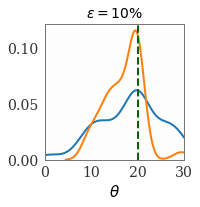

In [20]:
sns.kdeplot(posterior_samples_Vstat[:,0], color = "C0", linewidth = 2, linestyle = "solid", 
            label = "V-stat.")
sns.kdeplot(posterior_samples_weighted[:,0], color = "C1", linewidth = 2, linestyle = "solid", 
            label = "OW")
plt.axvline(true_theta, color = "darkgreen", linestyle = "dashed")
plt.xlabel("$\\theta$", fontsize = 15)
plt.ylabel("Density", fontsize = 15)
plt.xlim(0,30)
plt.legend(frameon = False, fontsize = 13.5, handletextpad=0.2)
plt.show()